# Research Question No. 3

## How frequent are, and what are the main characteristics of long-lived bugs?

## Experimental parameters


| Project                    |         #Reports     |       #Thesholds     |
|----------------------------|:--------------------:|:--------------------:|
| Eclipse                    |        10000         |         365          |
| GCC                        |        10000         |         365          |
| Gnome                      |        7993          |         365          |
| Freedesktop                |        7714          |         365          |
| Mozilla                    |        1000          |         365          |
| WineHQ                     |        6014          |         365          |

Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

## Step1. Setup environment.

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:

import matplotlib.pyplot as plt 
import nltk 
import numpy as np
import os 
import pandas as pd
import seaborn as sns 
import string
import re

from nltk.stem   import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import FuncFormatter

# Setup Seaborn
sns.set_context("paper")
sns.set(style="ticks", color_codes=True, font_scale=2)

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
%matplotlib inline 



# Setup NLTK
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')

# Path of the file to read.
projects = ['eclipse', 'freedesktop', 'gnome', 'mozilla', 'gcc', 'winehq']

# Fixed time threshold.
bug_fix_time_threshold = 365
print("Setup complete")

Setup complete


[nltk_data] Downloading package punkt to /home/gomes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gomes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Common Functions

In [4]:
def plot_pyramid (data, column, sort_column, filename):
  
    top_g = data.groupby(column)[column].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False)
    top_n = data.loc[data[column].isin(top_s.index)].groupby(column)['long_lived?'].value_counts(normalize=True).unstack()
    top_n.fillna(0, inplace=True)
    
    top_n.reset_index(inplace=True)
    top_n = top_n.sort_values(sort_column, ascending=True)
    
    print(top_n)
    
    fig, axes = plt.subplots(figsize=(10, 10), ncols=2, sharey=False, gridspec_kw = {'wspace':0, 'hspace':0})

    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = True

    sns.despine(offset=0.5)
    sns.barplot(x="long-lived", y=column, color="tab:red", ax=axes[0], data=top_n)
    sns.barplot(x="short-lived", y=column,  color="tab:blue", ax=axes[1], data=top_n)
    
    axes[0].set(xlim=(0, 1))
    axes[0].invert_xaxis()
    axes[0].spines['left'].set_visible(False)
    axes[0].tick_params(axis="x", labelsize=MEDIUM_SIZE)
    axes[0].tick_params(axis="y", labelsize=MEDIUM_SIZE)
    axes[0].set_ylabel(column.title().replace("_", " ").replace("Category", "Level"), fontsize=MEDIUM_SIZE)
    axes[0].set_xlabel("long-lived", fontsize=MEDIUM_SIZE)    
    axes[0].set_xticklabels(['{:,.0%}'.format(x) for x in axes[0].get_xticks()])
    
    axes[1].set(xlim=(0, 1))
    axes[1].set_yticks([])
    axes[1].set(ylabel="")
    axes[1].tick_params(axis="x", labelsize=MEDIUM_SIZE)
    axes[1].set_xlabel("short-lived", fontsize=MEDIUM_SIZE)
    axes[1].set_xticklabels(['{:,.0%}'.format(x) for x in axes[1].get_xticks()])
    
    #sns.despine(offset=0.5)
    s = axes[1].twinx()
    labels = [i.get_text() for i in axes[0].get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    s.set_yticks(axes[0].get_yticks())
    s.set_ylim(axes[0].get_ylim())
    s.set_yticklabels(labels_new)
    s.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    
    s.spines['top'].set_visible(False)
    s.spines['bottom'].set_visible(False)
    s.spines['right'].set_visible(False)
    s.spines['left'].set_visible(False)
        
    #fig.suptitle(project, fontsize=BIGGER_SIZE)
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')


## Step 2. Load data.

In [5]:
bug_reports_data_list = []
for project in projects:
    bug_reports_path = f"datasets/20190917_{project}_bug_report_data.csv"

    # read bug reports data.
    bug_reports_data = pd.read_csv(bug_reports_path)[0:10000]
    rows_and_cols = bug_reports_data.shape
    print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {bug_reports_path}.\n")
    print(f"Mean of bug fix time: {bug_reports_data['bug_fix_time'].mean(axis=0)}.\n")
   
    bug_reports_data["project"] = project  
    bug_reports_data_list.append(bug_reports_data) 

# concatenate all bug_reports_data 
bug_reports_all_data = pd.concat(bug_reports_data_list)

There are 10000 rows and 19 columns in datasets/20190917_eclipse_bug_report_data.csv.

Mean of bug fix time: 108.5303.

There are 7714 rows and 19 columns in datasets/20190917_freedesktop_bug_report_data.csv.

Mean of bug fix time: 173.19665543168264.

There are 7993 rows and 19 columns in datasets/20190917_gnome_bug_report_data.csv.

Mean of bug fix time: 202.4147378956587.

There are 10000 rows and 19 columns in datasets/20190917_mozilla_bug_report_data.csv.

Mean of bug fix time: 278.071.

There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

Mean of bug fix time: 337.8563.

There are 6074 rows and 19 columns in datasets/20190917_winehq_bug_report_data.csv.

Mean of bug fix time: 491.10273296015805.



In [6]:
bug_reports_history_data_list = []
for project in projects:
    bug_reports_history_path = f"datasets/20190917_{project}_bug_report_history_data.csv"

    # read bug reports data.
    bug_reports_history_data = pd.read_csv(bug_reports_history_path, sep=',')
 
    # print dataframe information
    rows_and_cols = bug_reports_history_data.shape
    print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {bug_reports_history_path}.\n")
    
    bug_reports_history_data_list.append(bug_reports_history_data) 

# concatenate all bug_reports_data 
bug_reports_all_history_data = pd.concat(bug_reports_history_data_list)

There are 79279 rows and 6 columns in datasets/20190917_eclipse_bug_report_history_data.csv.

There are 51724 rows and 6 columns in datasets/20190917_freedesktop_bug_report_history_data.csv.

There are 52102 rows and 6 columns in datasets/20190917_gnome_bug_report_history_data.csv.

There are 191270 rows and 6 columns in datasets/20190917_mozilla_bug_report_history_data.csv.

There are 98055 rows and 6 columns in datasets/20190917_gcc_bug_report_history_data.csv.

There are 60992 rows and 6 columns in datasets/20190917_winehq_bug_report_history_data.csv.



## Step 3. Review the data

In [7]:
bug_reports_all_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project
0,EMF-354412,2011-08-10,cdo.core,EMF,containsAll returns wrong result in case of de...,Cloned from: 354395: containsAll returns wrong...,stepper,stepper,fixed,1,closed,6,2012-09-21,0,5,2011-08-10,0,normal,2,eclipse
1,JSDT-253166,2008-11-03,General,JSDT,Javascript validation has several errors with ...,Some of our javascript-files yield parse-error...,cmjaun,acm,fixed,1,resolved,4,2010-03-03,0,6,2009-04-29,177,normal,2,eclipse
2,ECLIPSELINK-338573,2011-03-01,SDO,ECLIPSELINK,Memory Improvement: Reduce the instances of S...,Currently the SDO/OXM metadata is referring to...,blaise.doughan,blaise.doughan,fixed,1,resolved,4,2011-03-02,0,5,2011-03-02,1,normal,2,eclipse
3,BIRT-150200,2006-07-10,Chart,BIRT,Stacked Area Chart: fill.set() ignored in befo...,In the attached report the fill.set() is being...,nli,eclipse,fixed,1,resolved,4,2010-03-24,0,7,2006-08-29,50,major,4,eclipse
4,PAPYRUS-384964,2012-07-12,Core,PAPYRUS,[StateMachine Diagram] Papyrus does not forbid...,In some situation (seem to be when an element ...,ansgar.radermacher,yann.tanguy,fixed,1,resolved,4,2013-04-02,0,3,2013-04-02,264,critical,5,eclipse


In [8]:
bug_reports_all_data.describe()

,resolution_code,status_code,quantity_of_votes,quantity_of_comments,bug_fix_time,severity_code
count,51781.0,51781.000000,51781.000000,51781.000000,51781.000000,51781.000000
mean,1.0,4.409957,0.078832,8.664896,254.561982,2.355710
std,0.0,0.807380,1.303383,12.267116,542.361709,0.987261
min,1.0,4.000000,0.000000,0.000000,-1.000000,0.000000
25%,1.0,4.000000,0.000000,3.000000,3.000000,2.000000
50%,1.0,4.000000,0.000000,6.000000,29.000000,2.000000
75%,1.0,4.000000,0.000000,10.000000,235.000000,2.000000
max,1.0,6.000000,101.000000,810.000000,7294.000000,6.000000


In [9]:
bug_reports_all_data.drop(bug_reports_all_data.loc[bug_reports_all_data['bug_fix_time'] < 0].index, inplace=True)
bug_reports_all_data.loc[bug_reports_all_data['bug_fix_time'] < 0]

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project


## Step 4. Pre-processing the data

In [10]:
def stem_sentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=set()
    for word in token_words:
        stem_sentence.add(stemmer.stem(word))
        
    return ' '.join(list(stem_sentence))

def clean_text(text):
    """Clean a text.

    Parameters
    ----------
    text: string
        A text string.

    Returns
    -------
    text:string
        A modified initial text string
    """
    if text != text:
        return ' '

    replace_by_space = re.compile("[/(){}\[\]\|@,;]")
    replace_bad_symbols = re.compile('[^0-9a-z #+_]')
    english_stopwords = set(stopwords.words('english'))
    text = text.lower()
    text = replace_by_space.sub(' ', text)
    text = replace_bad_symbols.sub('', text)
    text = ' '.join(word for word in text.split() if word not in english_stopwords)
    return stem_sentence(text)

def get_file_size(project, bugid):
    bugid = re.findall(r"\d+$", bugid)[0]
    file_name=f"/home/gomes/Workspace/doctorate/data/{project}/xml/{project.upper()}-{bugid}.xml"
    info = os.stat(file_name) 
    return info.st_size * 0.000001
    

In [11]:
#bug_reports_all_data['short_description'] = bug_reports_all_data['short_description'].fillna("")
#bug_reports_all_data['long_description']  = bug_reports_all_data['long_description'].fillna("")
#bug_reports_all_data['short_description_words'] = bug_reports_all_data['short_description'].apply(lambda s: len(clean_text(s).split()))
#bug_reports_all_data['long_description_words']  = bug_reports_all_data['long_description'].apply(lambda s: len(clean_text(s).split()))
#bug_reports_all_data['long_lived?']  = bug_reports_all_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > bug_fix_time_threshold else 'short-lived')

#bug_reports_all_data.drop(bug_reports_all_data[bug_reports_all_data['severity_category'] == 'not set'].index, inplace=True)
#bug_reports_all_data.drop(bug_reports_all_data[bug_reports_all_data['bug_fix_time'] < 0 ].index, inplace=True)

bug_reports_path = f"datasets/bug_reports_all_data.csv"
bug_reports_all_data = pd.read_csv(bug_reports_path)

#bug_reports_dir   = os.path.join('/home/gomes/Workspace/doctorate/data/eclipse/xml/')
#bug_reports_files = os.listdir(bug_reports_dir)
#bug_reports_all_data['file_size'] = bug_reports_all_data.apply(lambda x: get_file_size(x['project'], x['bug_id']), axis=1)

#bug_reports_all_data.to_csv(bug_reports_path, index=False)

bug_reports_all_data.nlargest(10, 'file_size')

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,...,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,project,short_description_words,long_description_words,long_lived?,file_size
16941,MESA-111152,2019-07-17,Drivers/Vulkan/intel,MESA,[DXVK][Regression][BISECTED][SKL] Everything i...,Created attachment 144805\nScreenshots\n\nIt w...,idr,leozinho29_eu,fixed,1,...,8,2019-07-19,2,normal,2,freedesktop,8,123,short-lived,333.225502
10843,DRI-104975,2018-02-06,DRM/Intel,DRI,Delay in skl_disable_plane() causes a system f...,Created attachment 137193\nDrm logs with 0x1e ...,ville.syrjala,azhar.shaikh,fixed,1,...,92,2019-06-11,490,minor,2,freedesktop,5,155,long-lived,195.976005
10888,MESA-107212,2018-07-12,Drivers/DRI/i965,MESA,Dual-Core CPU E5500 / G45: RetroArch with reic...,Created attachment 140615\nReicast with bad gr...,kenneth,diego.viola,fixed,1,...,42,2018-08-11,30,normal,2,freedesktop,10,53,short-lived,126.846477
11599,MESA-103852,2017-11-22,Drivers/Vulkan/radeon,MESA,Rendering errors when running dolphin-emu with...,Created attachment 135676\ntext file containin...,mesa-dev,benclapp55,fixed,1,...,22,2018-05-15,174,normal,2,freedesktop,11,131,short-lived,122.073290
12254,MESA-104711,2018-01-20,Drivers/DRI/i965,MESA,[skl CCS] Oxenfree (unity engine game) hangs GPU,Created attachment 136863\ngpu crash dump\n\nE...,jason,fdo,fixed,1,...,8,2018-01-25,5,normal,2,freedesktop,8,91,short-lived,96.466253
15880,DRI-101461,2017-06-16,DRM/Intel,DRI,[SKL] Unplugging the HDMI/DP/mDP cable from do...,Created attachment 131992\nKernel log (drm.deb...,dhinakaran.pandiyan,ethan.hsieh,fixed,1,...,20,2017-08-08,53,normal,2,freedesktop,10,94,short-lived,84.572128
17351,MESA-111231,2019-07-27,Drivers/Gallium/radeonsi,MESA,random VM_L2_PROTECTION_FAULTs when loading a ...,When playing minetest on an AMD ryzen 2200G wi...,dri-devel,ds2.bugs.freedesktop,fixed,1,...,18,2019-08-08,12,major,4,freedesktop,10,190,short-lived,62.166051
14864,DRI-100322,2017-03-22,DRM/Intel,DRI,[BDW][EXT] igt@drv_suspend@fence-restore-tiled...,On extended run igt@drv_suspend@fence-restore-...,intel-gfx-bugs,jani.saarinen,fixed,1,...,3,2017-05-03,42,normal,2,freedesktop,6,7,short-lived,38.970833
17416,XORG-93864,2016-01-25,Driver/intel,XORG,Performance degradation when one display is in...,My system has chipset 915GM configured in dual...,chris,franck.delache,fixed,1,...,12,2016-01-27,2,major,4,freedesktop,5,52,short-lived,37.384609
15530,DRI-104082,2017-12-04,DRM/AMDgpu,DRI,amdgpu 0000:07:00.0: swiotlb buffer is full (s...,With latest AMD staging driver and Vega 56 I h...,dri-devel,mikhail.v.gavrilov,fixed,1,...,51,2018-05-01,148,normal,2,freedesktop,8,262,short-lived,36.742946


In [12]:
bug_reports_all_data['project'].value_counts()

eclipse        9998
mozilla        9998
gcc            9998
gnome          7991
freedesktop    7712
winehq         6073
Name: project, dtype: int64

## Step 6. Bug Reporter

In [13]:
def plot_abc(project, column, n=None):
    from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
    """
    plots a pareto chart.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    data = data.groupby(column)[column].agg(['count'])
    data = data.sort_values(by='count',ascending=False)
    data['acumulado'] = data['count'].cumsum() / data['count'].sum()
    performance = data['acumulado'].tolist()
    y_pos = np.arange(len(performance))
    y_pos = (y_pos / max(y_pos))
    
    # Change major ticks to show every 500.
    ax.xaxis.set_major_locator(MultipleLocator(0.20))
    ax.yaxis.set_major_locator(MultipleLocator(0.20))

    # Change minor ticks to show every 5. (20/4 = 5)
  
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    plt.title(project.capitalize())
    plt.grid(True)
    plt.plot(y_pos, performance, color='tab:blue')
    plt.ylabel('% of bug reports')
    plt.ylim(0, 1)
    plt.xlabel("% of {}".format(column.replace("_name", "")+"s"))
    plt.xlim(0, 1)
 
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')
 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
 
    index = np.argmin(np.abs(np.array(y_pos)-0.2))
    plt.axvline(x=.2, color='gray',linestyle='--')
    plt.axhline(y=performance[index],color='gray',linestyle='--')

    plt.scatter(.2, performance[index], color='tab:blue' )
    
    plt.show()
    
def plot_pareto(project, column, n=10):
    """
    plots a pareto chart.
    
    """
    data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    data = data.groupby(column)[column].agg(['count'])
    data = data.sort_values(by='count',ascending=False)
    data['acumulado'] = data['count'].cumsum() / data['count'].sum()
    
    fig, axes = plt.subplots(figsize=(10,5))
    ax1 = data.head(n).plot(use_index=True, y='count',  kind='bar', ax=axes)
    ax2 = data.head(n).plot(use_index=True, y='acumulado', marker='D', color="C1", kind='line', ax=axes, secondary_y=True)

    ax1.set(title=project.capitalize(), ylabel="Bugs Reports")
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend().set_visible(False)
    
    ax2.set(ylim=(0, 1.1), ylabel="Cumulative Percentage")
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

def plot_pareto_modificado(project, column, n=10):
    """
    plots a pareto chart modificado.
    
    """
    data = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    data = data.groupby(column)[column].agg(['count'])
    data = data.sort_values(by='count',ascending=False)
    data['acumulado'] = data['count'].cumsum() / data['count'].sum()
    data['acumulado_label'] = data['acumulado'] * 100
    data.set_index('acumulado_label', inplace=True)
    fig, axes = plt.subplots(figsize=(20,10))
    
    ax1 = data.plot(use_index=True, y='count',  kind='bar', ax=axes)
    ax2 = data.plot(use_index=True, y='acumulado', marker='D', color="C1", kind='line', ax=axes, secondary_y=True)
    
    ax1.set(title=project.capitalize(), ylabel="Bugs Reports")
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend().set_visible(False)
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    
    ax2.set(ylim=(0, 1.1), ylabel="Cumulative Percentage")
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    
    
def plot_bar (project, column, ax):
    from matplotlib.ticker import FuncFormatter
    top_10 = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    top_10 = top_10.groupby(column)[column].agg(['count'])
    top_10 = top_10.sort_values('count', ascending=False).head(10)
    
    bug_reports_data_for_top_10=bug_reports_all_data[bug_reports_all_data[column].isin(top_10.index)]
    top_10_grouped = bug_reports_data_for_top_10.groupby(column)['long_lived?'].value_counts(normalize=True).unstack()
    top_10_grouped.plot(kind='bar', stacked='True', color=["tab:red", "tab:blue"], ax=ax)
    ax.legend()
    ax.set(ylim=(0, 1))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))    
    ax.set(title=project.capitalize(), xlabel="", ylabel="")
    

def plot_s_bar (bugs, column, n, filename):
    from matplotlib.ticker import FuncFormatter
    top_n_df = pd.DataFrame(columns=['Project', 'Label', 'Value']) 
    
    for project in projects:
        data   = bugs.loc[bugs['project']==project]
        top_g  = data.groupby(column)[column].agg(['count'])
        top_s  = top_g.sort_values('count', ascending=False).head(n)
        value    = top_s['count'].sum() / data.shape[0]
        
        top_n_df = top_n_df.append({'Project': project.capitalize(), 'Label': 'others',   'Value': 1 - value}, ignore_index=True)
        top_n_df = top_n_df.append({'Project': project.capitalize(), 'Label': f"top {n}", 'Value': value}, ignore_index=True)
    
    
    top_n_df_pivot = top_n_df.pivot(index='Project', columns='Label', values='Value')
    ax = top_n_df_pivot.plot.bar(stacked=True, color=["tab:green", "tab:orange"], figsize=(10,7))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)   
 
    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = False
    ax.yaxis.grid(linestyle=':')
    
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel("", fontsize=MEDIUM_SIZE)
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))    
    ax.set(ylim=(0, 1))
 
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, shadow=False, ncol=5)

    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')
    
def plot_topn_pie (project, data, column, n, filename):
    
    data   = data.loc[data['project']==project]
    top_g  = data.groupby(column)[column].agg(['count'])
    top_s  = top_g.sort_values('count', ascending=False).head(n)
    
    labels    = [f"Top {n}"]
    top_n     = top_s.reset_index()
    values    = [top_s['count'].sum()] 
    labels.append('Others')
    values.append(data.shape[0] - sum(values))
    
    fig = plt.figure(figsize=(6,6))

    ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
    ax1.pie(values, labels=labels
            , autopct='%1.1f%%'
            , colors=["tab:green", "tab:orange"]
            , textprops={'fontsize': SMALL_SIZE-1})
    
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')


def plot_top_n_pie(column, n=10):
    
    def plot_pie(v, l, color=None):
        plt.pie(v
                , labels=l.values
                , autopct='%1.1f%%'
                , colors=["tab:green", "tab:orange"]
                , textprops={'fontsize': MEDIUM_SIZE-4})
        plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')
    

    top_10_summary = pd.DataFrame(columns=['project', 'count', 'pct', 'category'])
                                       
    for i in range(6):
        project = projects[i]
        all_bugs = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
        top_10 = all_bugs.groupby(column)[column].agg(['count'])
        top_10 = top_10.sort_values('count', ascending=False).head(n)
        top_10_summary.loc[top_10_summary.shape[0]+1] = (project
                                                         , top_10['count'].sum()
                                                         , top_10['count'].sum()/all_bugs['bug_id'].count()
                                                         , f"Top {n}")
        top_10_summary.loc[top_10_summary.shape[0]+1] = (project
                                                         , all_bugs['bug_id'].count()-top_10['count'].sum()
                                                         , (all_bugs['bug_id'].count()-top_10['count'].sum())/all_bugs['bug_id'].count()
                                                         , 'Others')

    projects_ordered = top_10_summary.loc[top_10_summary.category==f"Top {n}"].sort_values('project')['project']

    #plot pie charts
    #sns.set(style="ticks", color_codes=True, font_scale=2.0)
        
    g = sns.FacetGrid(top_10_summary, col="project", col_wrap=3, height=8
                  , col_order=projects_ordered
                  , aspect=1.5)
    g = g.map(plot_pie, "count", "category")
    g.set(ylabel="", xlabel="")
    g.set_titles("{col_name}", fontsize=MEDIUM_SIZE)

In [14]:
# -------------------------------------- DEBUG ------------------------------------------
data = bug_reports_all_data.loc[bug_reports_all_data['project']=='winehq']
total = len(data)
count = len(data['reporter_name'].value_counts())
percentage = int(count * 0.2)
percentage_in_20_perc = (sum(data['reporter_name'].value_counts()[0:percentage])) / total
display(percentage_in_20_perc)
# ------------------------------------- DEBUG ------------------------------------------

0.6362588506504199

<Figure size 432x288 with 0 Axes>

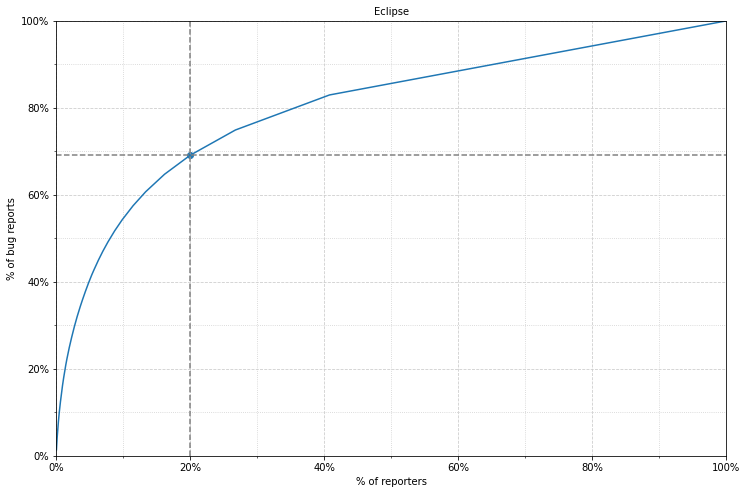

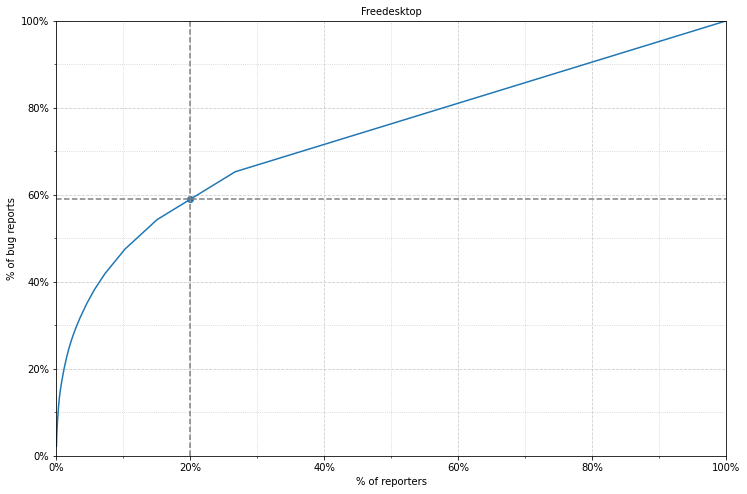

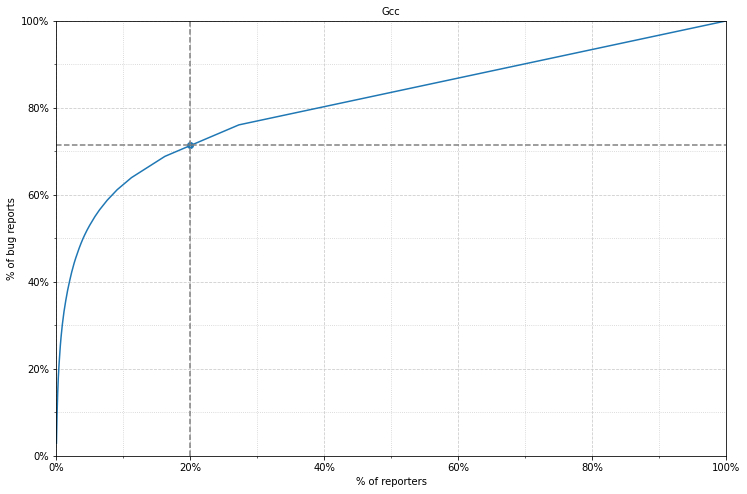

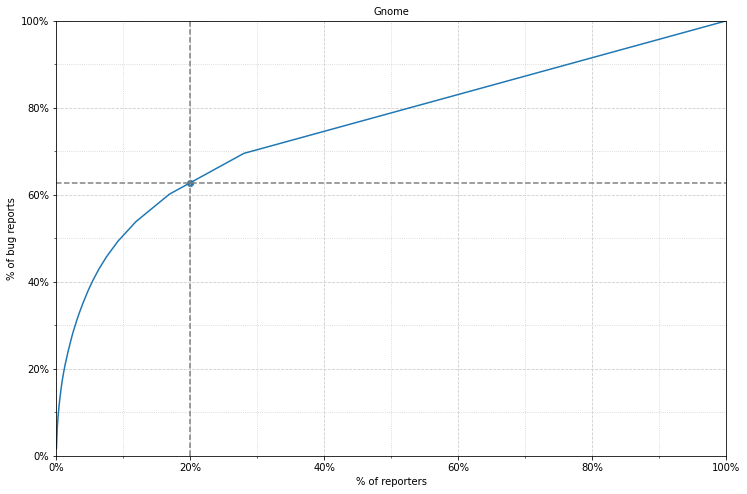

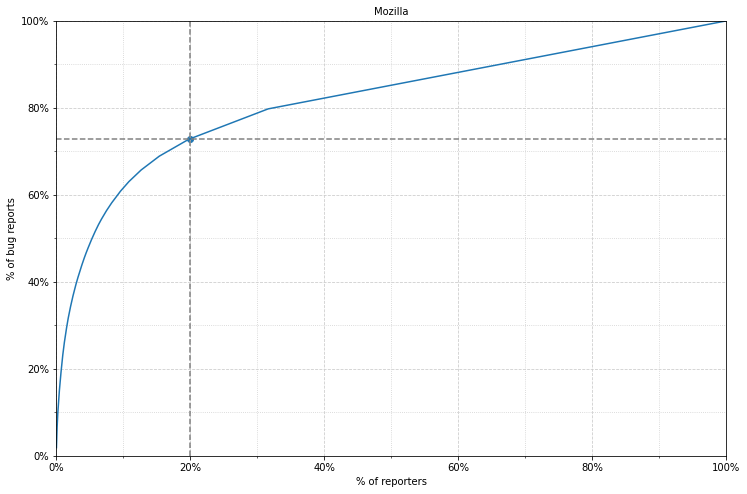

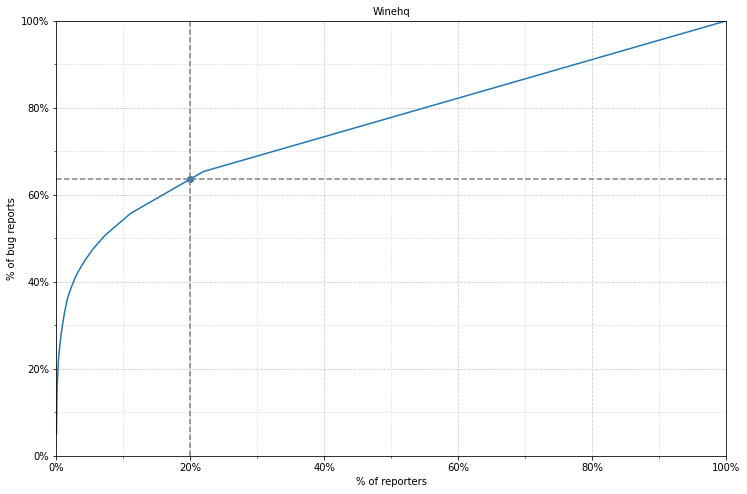

In [15]:
# abc plot.
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
projects=['eclipse', 'freedesktop', 'gcc', 'gnome', 'mozilla', 'winehq']
plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False    
for project in projects:
    plot_abc(project, 'reporter_name', 100)


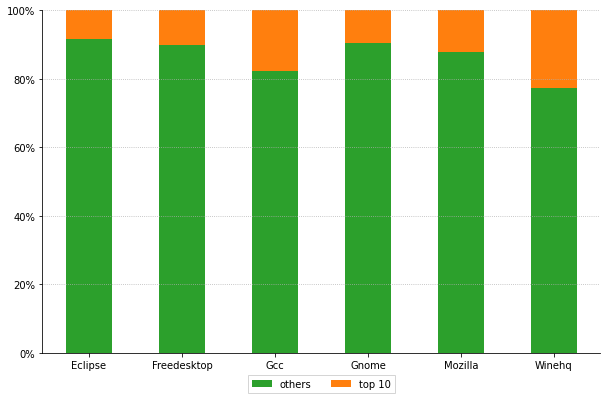

In [16]:
plot_s_bar(bug_reports_all_data, 'reporter_name', 10, 'rq3-all-top_n-reporter_name-pct.pdf')

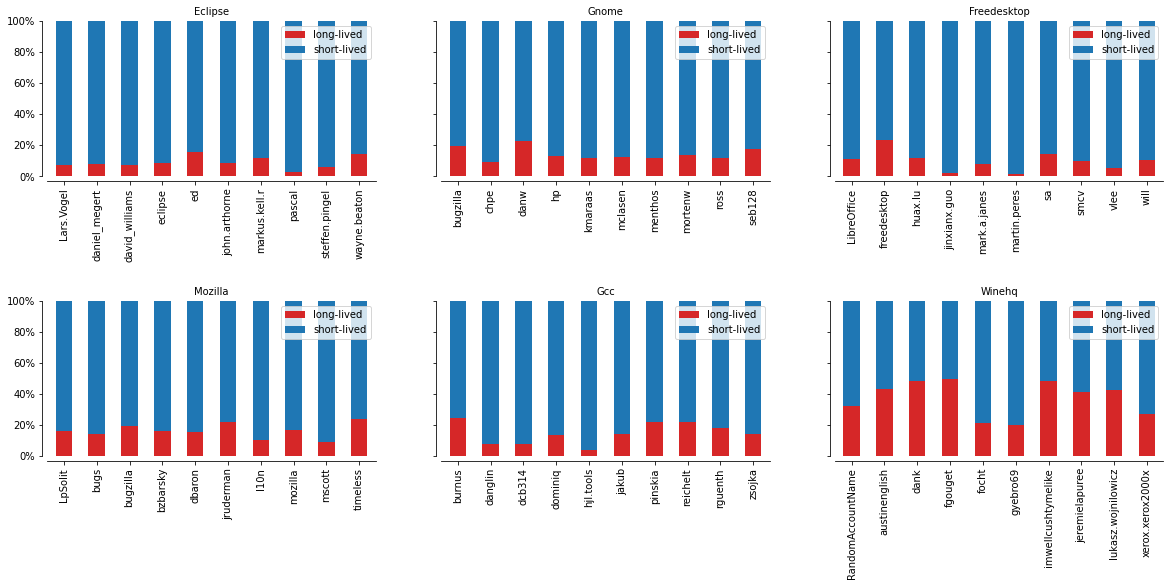

In [17]:
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
projects=['eclipse', 'gnome', 'freedesktop', 'mozilla', 'gcc', 'winehq']
plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False    
for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'reporter_name', ax)

plt.savefig("figures/rq3-percentage-of-long-lived-bugs-by-bug-reporter.pdf", format="pdf", dpi=600, bbox_inches='tight')


## Step 7. Assignee

In [18]:
# -------------------------------------- DEBUG ------------------------------------------
data = bug_reports_all_data.loc[bug_reports_all_data['project']=='winehq']
total = len(data)
count = len(data['assignee_name'].value_counts())
percentage = int(count * 0.2)
percentage_in_20_perc = (sum(data['assignee_name'].value_counts()[0:percentage])) / total
display(percentage_in_20_perc)
# ------------------------------------- DEBUG ------------------------------------------

0.9749711839288655

<Figure size 432x288 with 0 Axes>

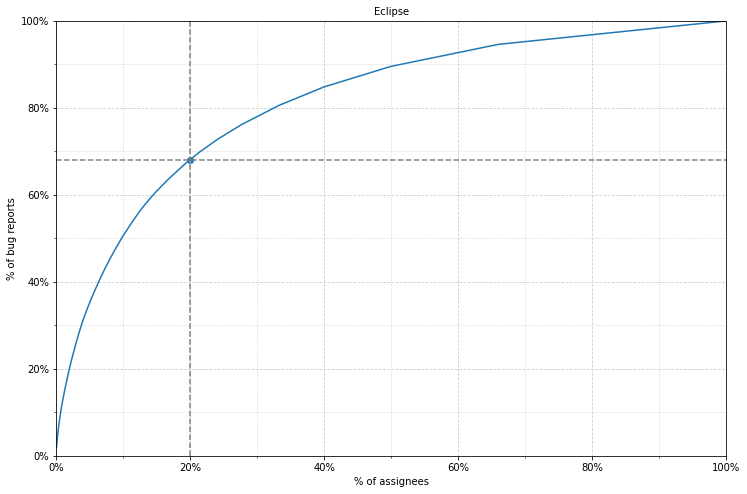

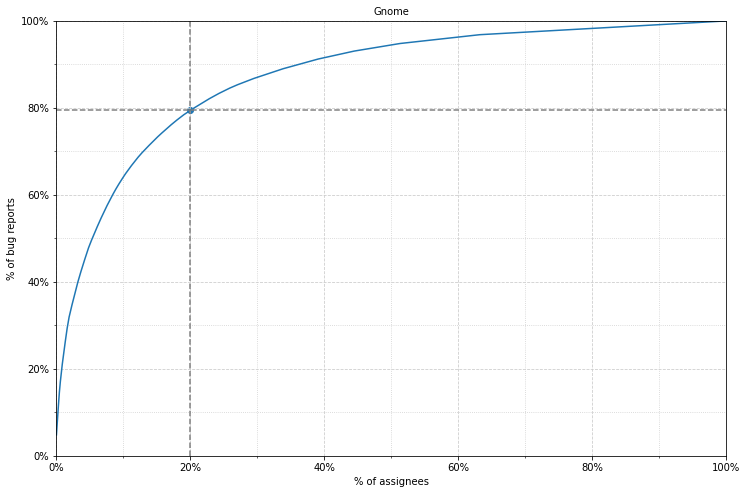

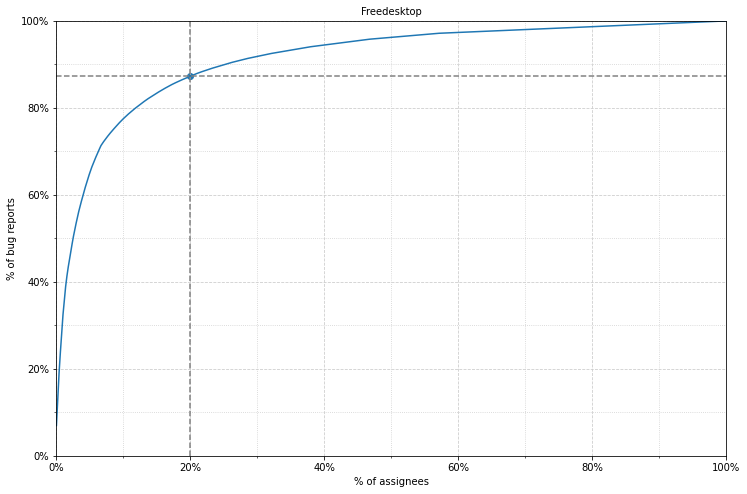

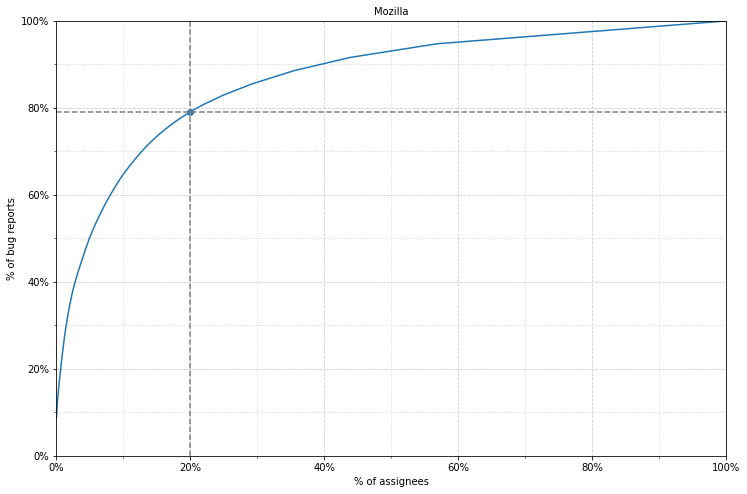

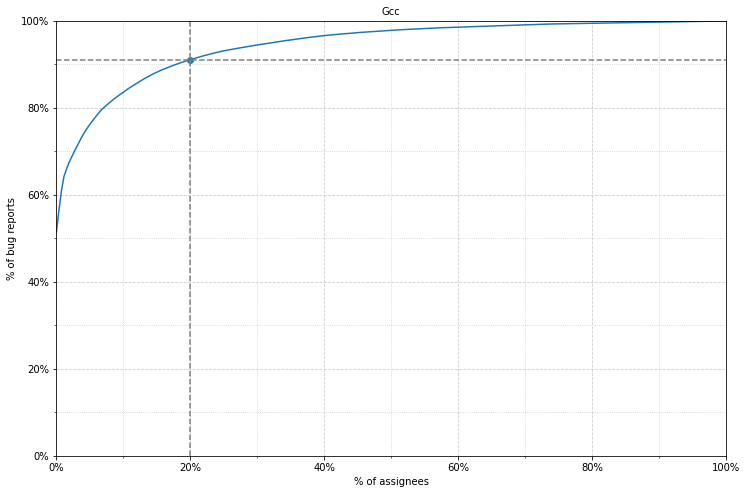

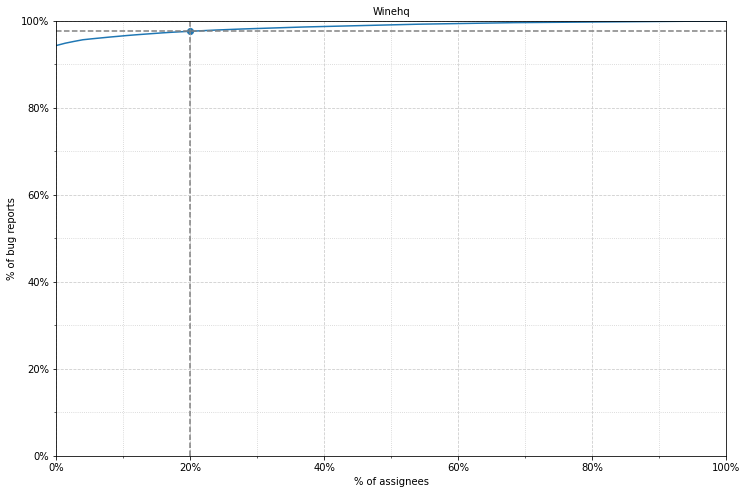

In [19]:
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
projects=['eclipse', 'gnome', 'freedesktop', 'mozilla', 'gcc', 'winehq']
plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False    
for project in projects:
    plot_abc(project, 'assignee_name', 100)


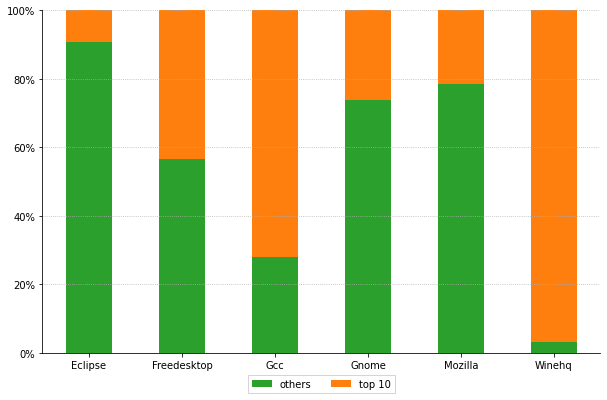

In [20]:
plot_s_bar(bug_reports_all_data, 'assignee_name', 10, 'rq3-all-top_n-assignee_name-pct.pdf')

## 7.1 Short-lived vs. Long-lived by Top 10 Assignee

In [21]:
data = bug_reports_all_data.loc[bug_reports_all_data['project']=='winehq']
(data['assignee_name'].value_counts()/data['assignee_name'].value_counts().sum()).head(10)

wine-bugs          0.943521
jnewman            0.005269
mike               0.004117
us                 0.003787
truiken            0.002141
00cpxxx            0.001976
eric.pouech        0.001976
dpaun              0.001811
stefandoesinger    0.001811
apa3a              0.001647
Name: assignee_name, dtype: float64

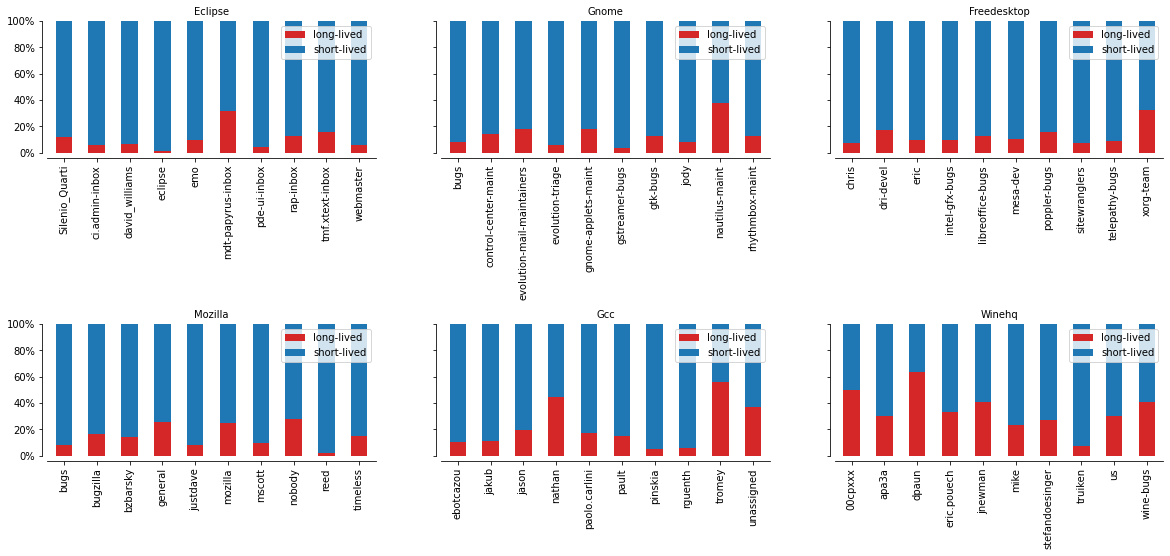

In [22]:
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=1.3)
sns.despine(offset=5)
for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'assignee_name', ax)

plt.savefig("figures/rq3-percentage-of-long-lived-bugs-by-assignee.pdf", format="pdf", dpi=600, bbox_inches='tight')


## Step 8. Component

<Figure size 432x288 with 0 Axes>

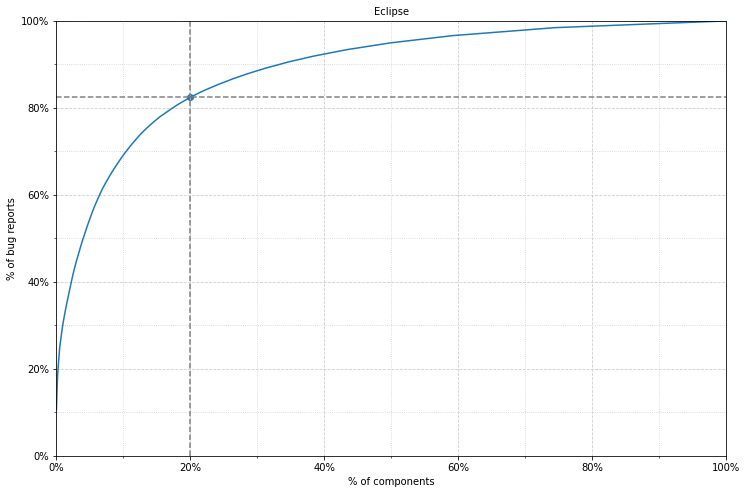

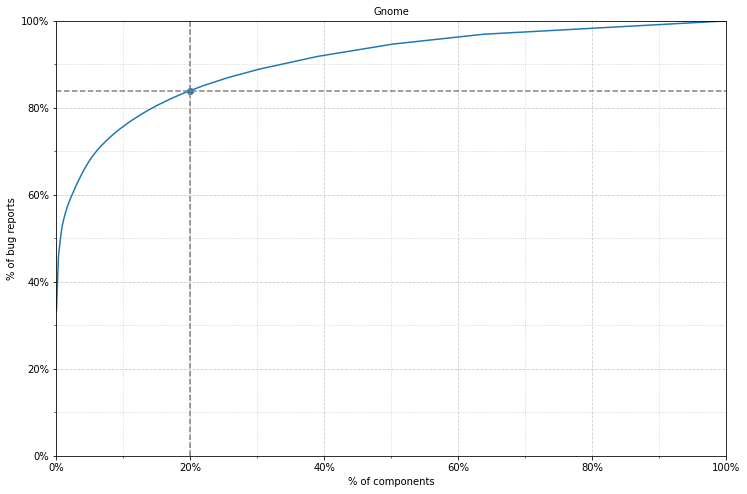

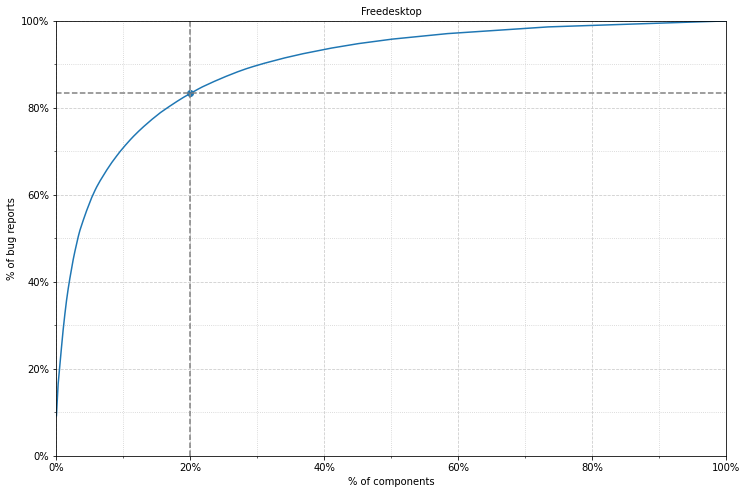

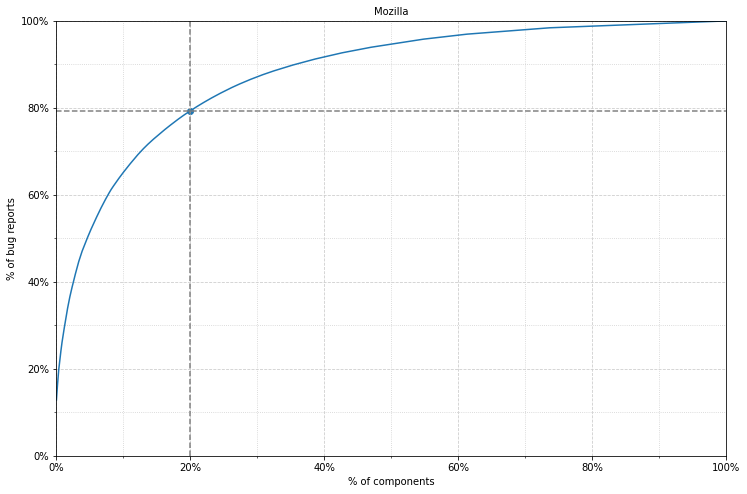

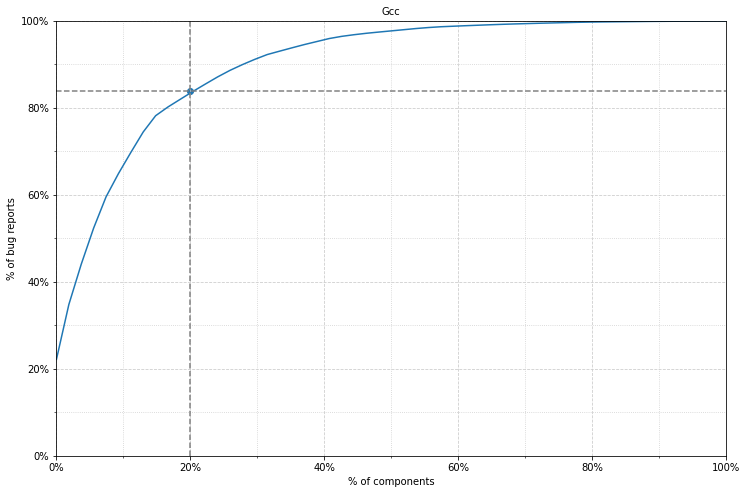

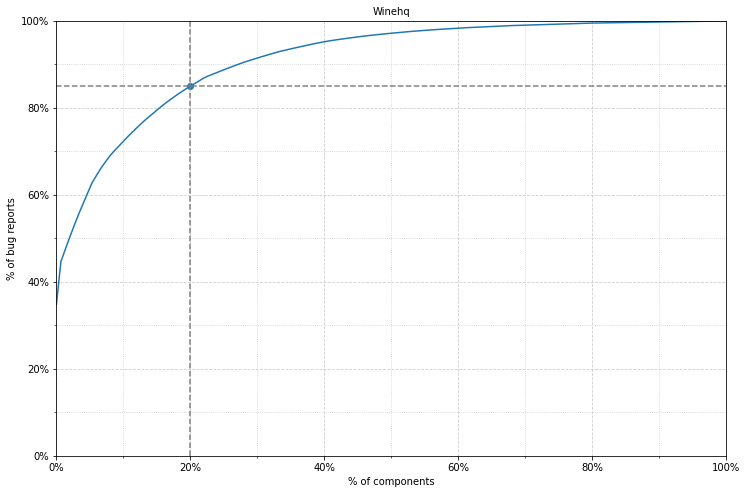

In [23]:
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
projects=['eclipse', 'gnome', 'freedesktop', 'mozilla', 'gcc', 'winehq']
plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False    
for project in projects:
    plot_abc(project, 'component_name', 100)

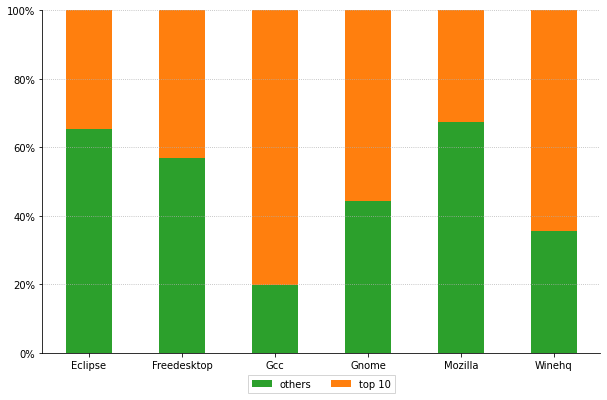

In [24]:
plot_s_bar(bug_reports_all_data, 'component_name', 10, 'rq3-all-top_n-component_name-pct.pdf')

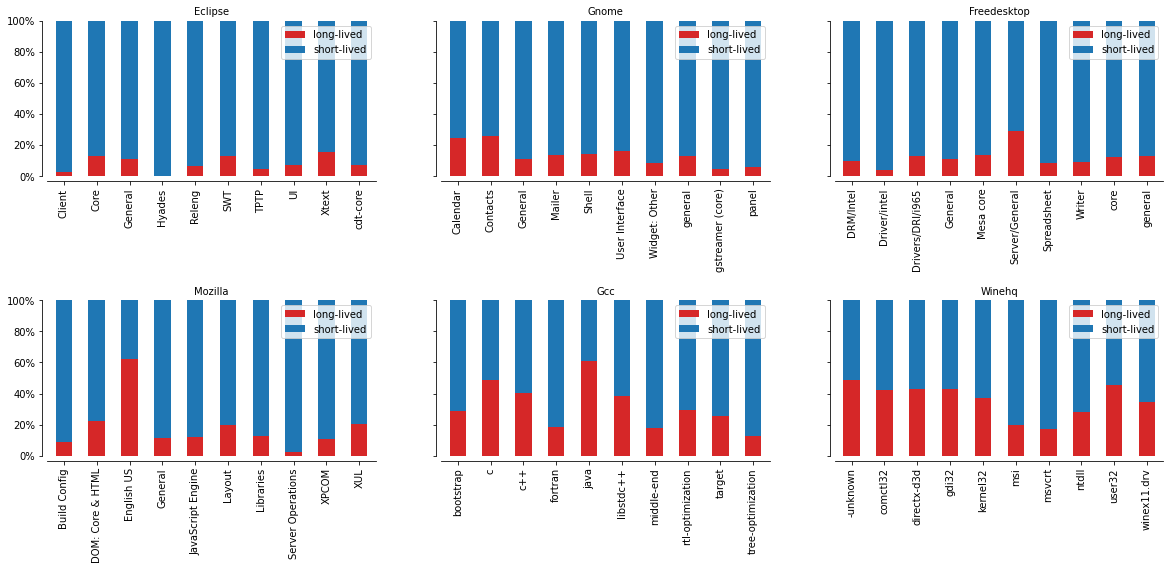

In [25]:
# stacked bar plot.
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(20,8))
plt.subplots_adjust(hspace=0.8)
sns.despine(offset=5)
for project, ax in zip(projects, axes.flatten()):
    plot_bar(project, 'component_name', ax)
    
plt.savefig("figures/rq3-percentage-of-long-lived-bugs-by-component.pdf", format="pdf", dpi=600, bbox_inches='tight')


## Step 9. Analysis of Short and Long Descrption

### 9.1 - Short Description Word cloud

In [26]:
from PIL import Image
import matplotlib

def join_all_descriptions(descriptions):
    text = " ".join(description for description in descriptions)
    return text.lower()

def plot_one_word_cloud(text, title, axe, stopwords=""):
    if (stopwords==""):
        sl_wordcloud = WordCloud(width=900
                      , height=500
                      , background_color='white'
                      , max_words=100
                      , colormap=matplotlib.cm.inferno
                      , relative_scaling=0
                      , normalize_plurals=False).generate(text)
    else:
        sl_wordcloud = WordCloud(width=900
                      , height=500
                      , background_color='white'
                      , max_words=100
                      , colormap=matplotlib.cm.inferno
                      , relative_scaling=0
                      , normalize_plurals=False
                      , stopwords=stopwords).generate(text)
    axe.imshow(sl_wordcloud, interpolation='bilinear')
    axe.set_title(title, fontsize=20)
    axe.axis("off")



def plot_all_word_clouds(sl_descriptions, ll_descriptions, title, apply_text_mining=False):
    fig, ax = plt.subplots(figsize=(30,30), ncols=2)

    sl_text = join_all_descriptions(sl_descriptions)
    ll_text = join_all_descriptions(ll_descriptions)

    if (apply_text_mining):
        # Load stop words
        stop_words = stopwords.words('english')
        stop_words.extend(['wine', 'dll', 'window', 'project'
                           , 'view', 'editor', 'file', 'test'
                           , 'update', 'will', 'crashes', 'crash', 'gcc'])
       
        sl_text = sl_text.translate(str.maketrans('', '', string.punctuation))
        ll_text = ll_text.translate(str.maketrans('', '', string.punctuation))
        
        sl_text = ' '.join([word for word in sl_text.split() if word not in stop_words])
        ll_text = ' '.join([word for word in ll_text.split() if word not in stop_words])
        
        sl_text = stem_sentence(sl_text)
        ll_text = stem_sentence(ll_text)
        
    plot_one_word_cloud(sl_text, '{}: Short-Lived Bugs'.format(title), ax[0])
    plot_one_word_cloud(ll_text, '{}: Long-Lived Bugs'.format(title), ax[1])


In [27]:
#plot_all_word_clouds(bug_reports_all_data[bug_reports_all_data['long_lived?']=='short-lived'].short_description, bug_reports_all_data[bug_reports_all_data['long_lived?']=='long-lived'].short_description, 'Summary')
#plt.savefig(f"figures/rq3-all-short_description-wordcloud.pdf", format="pdf", dpi=600, bbox_inches='tight')


### 9.2 - Long Description Word cloud

In [28]:
#plot_all_word_clouds(bug_reports_all_data[bug_reports_all_data['long_lived?']=='short-lived'].long_description,
#                     bug_reports_all_data[bug_reports_all_data['long_lived?']=='long-lived'].long_description,
#                    'Description', False)
#plt.savefig(f"figures/rq3-all-long_description-wordcloud.pdf", format="pdf", dpi=600, bbox_inches='tight')


### 9.3 Long Description Size

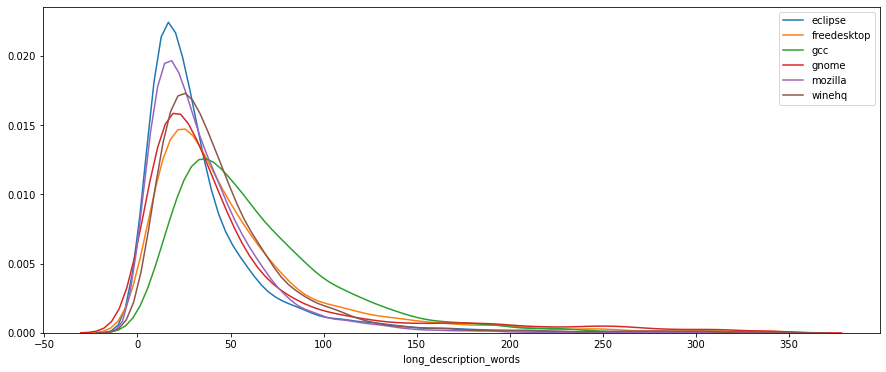

In [29]:
fig, ax   = plt.subplots(figsize=(15, 6))
threshold = 350
df   = bug_reports_all_data.loc[(bug_reports_all_data["long_description_words"] < threshold)] 
eclipse   = df.loc[(df["project"]=="eclipse")]["long_description_words"] 
sns.distplot(eclipse, hist=False, label="eclipse")
freedesktop = df.loc[(df["project"]=="freedesktop")]["long_description_words"] 
sns.distplot(freedesktop, hist=False, label="freedesktop")
gcc = df.loc[(df["project"]=="gcc")]["long_description_words"] 
sns.distplot(gcc, hist=False, label="gcc")
gnome = df.loc[(df["project"]=="gnome")]["long_description_words"] 
sns.distplot(gnome, hist=False, label="gnome")
mozilla = df.loc[(df["project"]=="mozilla")]["long_description_words"] 
sns.distplot(mozilla, hist=False, label="mozilla")
winehq = df.loc[(df["project"]=="winehq")]["long_description_words"] 
sns.distplot(winehq, hist=False, label="winehq")

<Figure size 432x288 with 0 Axes>

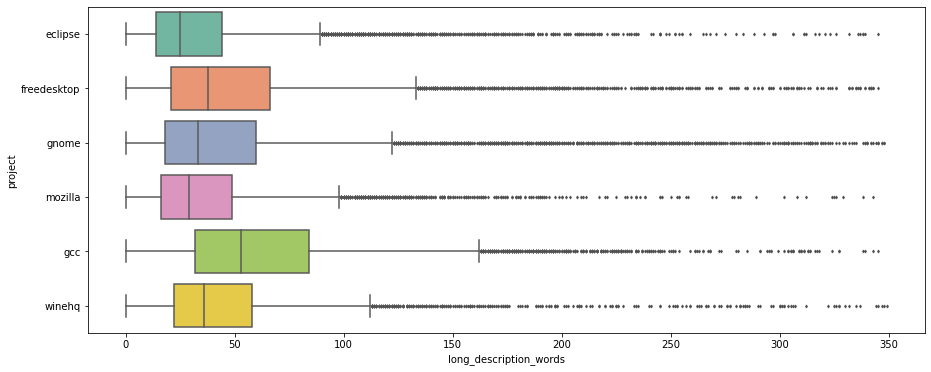

In [30]:
sns.despine(offset=10)
fig, ax = plt.subplots(figsize=(15, 6))
threshold = 350
df   = bug_reports_all_data.loc[(bug_reports_all_data["long_description_words"] < threshold)] 
g = sns.boxplot(data=df, x="long_description_words", y="project"
                , palette="Set2", ax=ax, flierprops = dict(markerfacecolor = '.10', markersize = 2))


### 9.4 Bug Reports File Size Distribution

<Figure size 432x288 with 0 Axes>

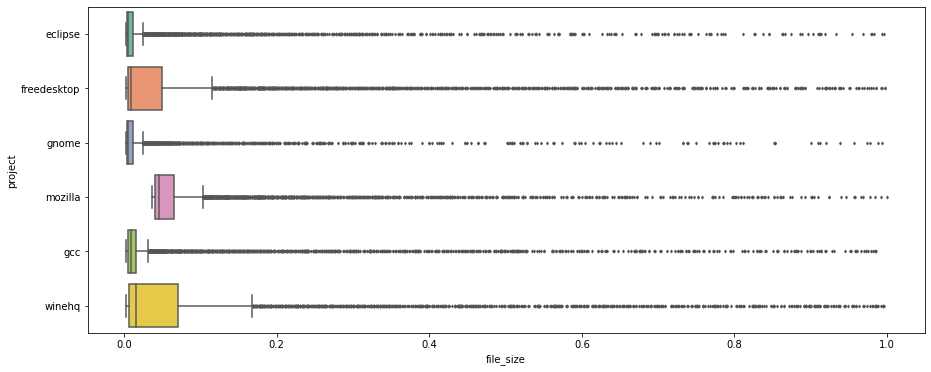

In [32]:
sns.despine(offset=10)
fig, ax = plt.subplots(figsize=(15, 6))
threshold = 1
df   = bug_reports_all_data.loc[(bug_reports_all_data["file_size"] < threshold)] 
g = sns.boxplot(data=df, x="file_size", y="project"
                , palette="Set2", ax=ax, flierprops = dict(markerfacecolor = '.10', markersize = 2))

## Step 10. Analysis of Severity Level

### Severity level distribution

long_lived? severity_category  long-lived  short-lived
0                     blocker    0.019231     0.980769
1                    critical    0.029973     0.970027
2                       major    0.076289     0.923711
3                       minor    0.120513     0.879487
4                      normal    0.077439     0.922561
5                     trivial    0.112500     0.887500
long_lived? severity_category  long-lived  short-lived
0                     blocker    0.037313     0.962687
1                    critical    0.095607     0.904393
2                       major    0.120588     0.879412
3                       minor    0.223404     0.776596
4                      normal    0.145231     0.854769
5                     trivial    0.175896     0.824104
long_lived? severity_category  long-lived  short-lived
0                     blocker    0.042918     0.957082
1                    critical    0.105376     0.894624
2                       major    0.156085     0.843915
3         

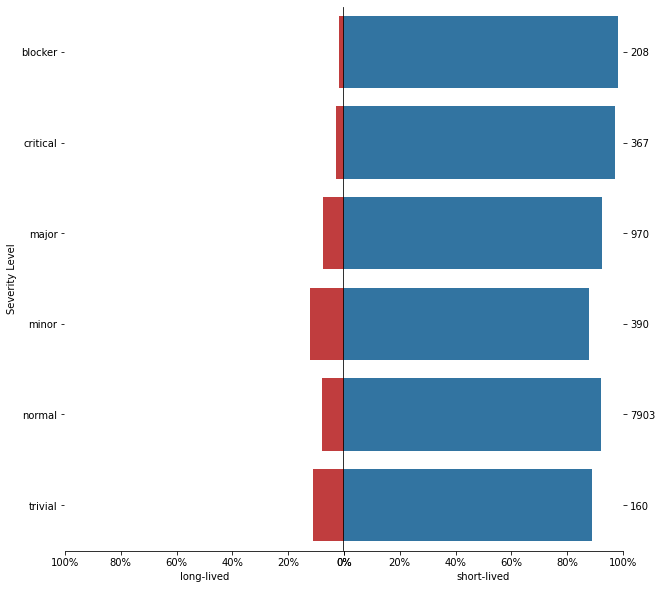

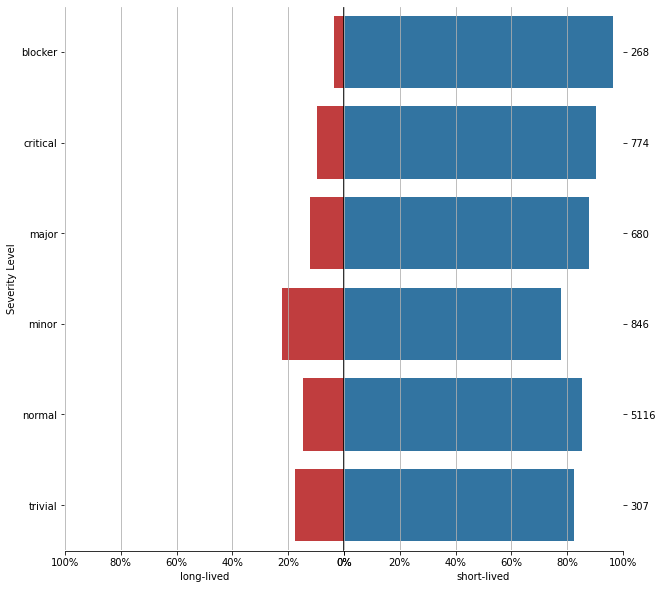

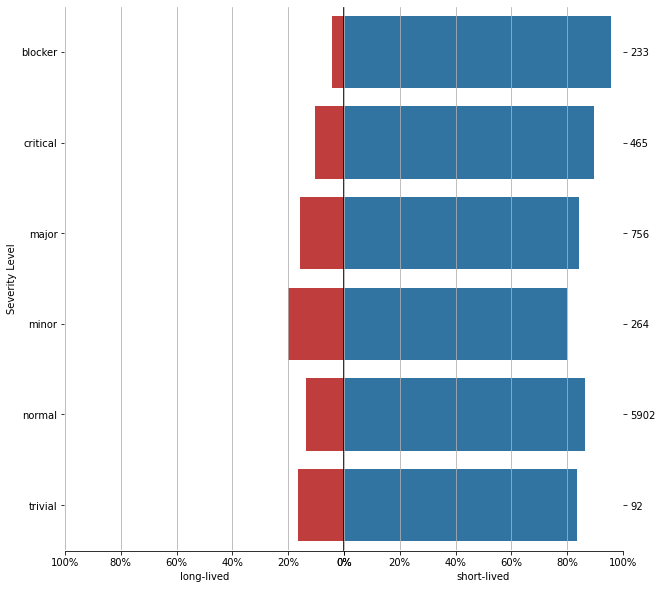

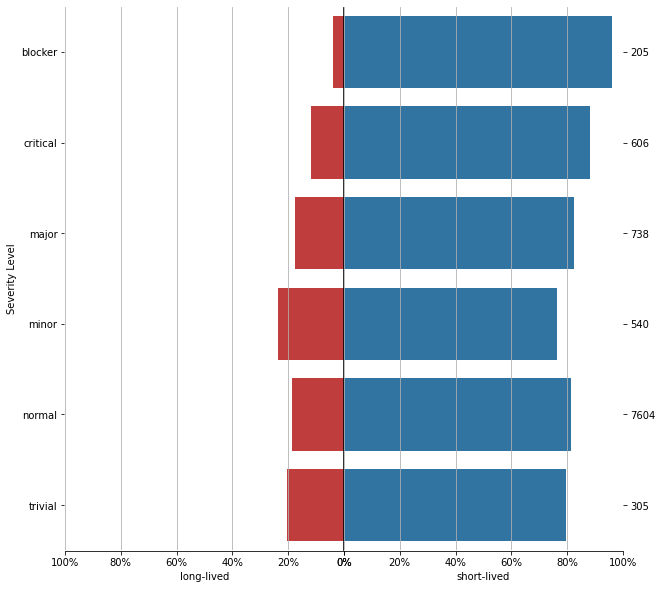

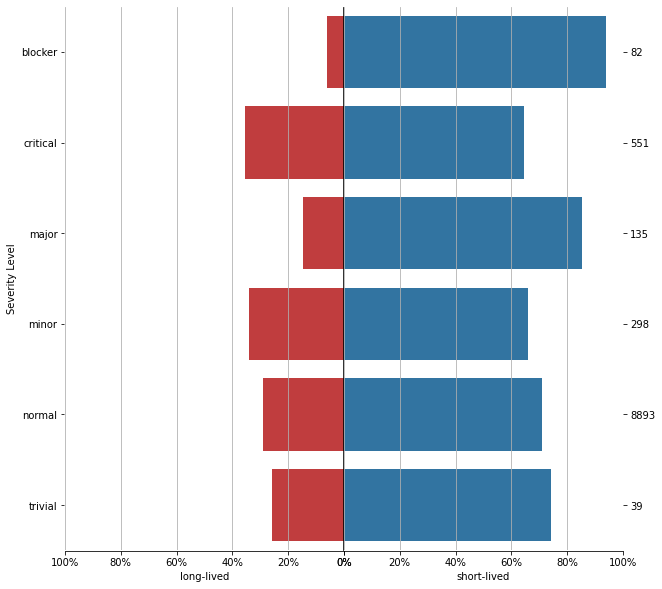

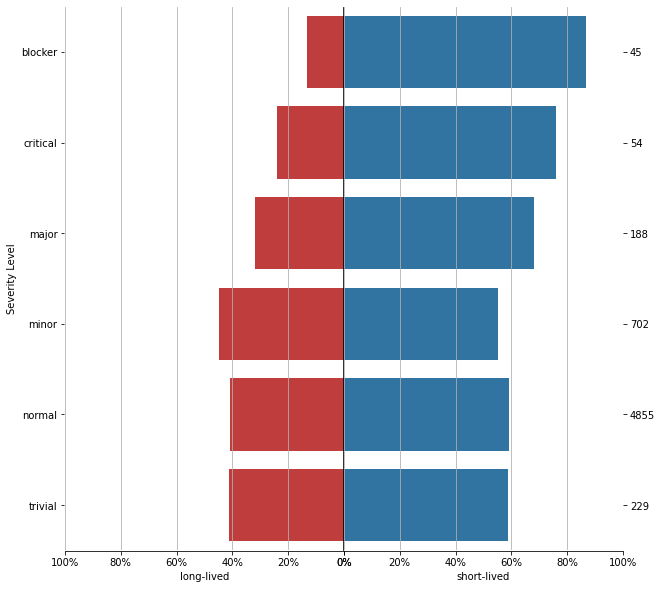

In [47]:
for project in projects:
    bug_reports_all_data_by_project = bug_reports_all_data.loc[bug_reports_all_data['project']==project]
    filename = f"rq3-{project}-ll-sl-severity_level.pdf"
    plot_pyramid (bug_reports_all_data_by_project, 'severity_category', 'severity_category', filename)
